<img src="header_profi.png" align="left"/>

# Anwendungsbeispiel Incremental/active learning and optimization

Das Ziel dieses Beispiels ist die Erklärung von **incremental learning** und **active learning**. Dabei wird versucht aus neuen Daten weitere Trainingsdaten zu generieren mit denen ein Modell verbessert werden kann. Im zweiten Teil wird noch die Technik der **hyperparameter optimization** vorgestellt.


Der Code für die hyperparameter optimization wurde aus [1] entlehnt.

- [1] [https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce)


Referenz auf den EMNIST Datensatz:
```
EMNIST: Extending MNIST to handwritten letters, Cohen, Gregory and Afshar, Saeed and Tapson, Jonathan and Schaik, Andre Van, 2017 International Joint Conference on Neural Networks (IJCNN), 2017
```

# Import der Module  

In [1]:
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 14]

# Incremental Learning

Bei incremental learning werden aus neuen Daten mit Hilfe von Regeln neue Trainingsdaten extrahiert und damit ein Modell neu trainiert. Wir werden sehen, ob das funktioniert.

Mehr zu incremental learning unter [https://en.wikipedia.org/wiki/Incremental_learning](https://en.wikipedia.org/wiki/Incremental_learning)

<img src="info.png" align="left"/> 


## Das alte Modell

In [3]:
#
# Parameter für Modell
#
prefix = 'results/04_'
modelName = prefix + "model.json"
weightName = prefix + "model.h5"

In [4]:
#
# Laden des vortrainierten Modelles aus Anwendungsbeispiel 04
#
json_file = open(modelName, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weightName)
print("loaded model from disk")

loaded model from disk


In [5]:
#
# Vorbereitung für Test
#
optimizer = Adam(learning_rate=0.001)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
#
# MNIST Daten (wurden für das Trainings des alten Modelles verwendet)
#
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
x_test.shape

(10000, 28, 28, 1)

In [7]:
#
# Messen der Accuracy des alten Modelles
#
_, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy {:.5f}'.format(acc))

Accuracy 0.99110


In [8]:
#
# Speichern für später
#
oldModelAccuracy = acc

In [9]:
#confusion_matrix(y_test, y_pred)

# Neue Daten aus dem echten Betrieb

Wir simulieren neue Daten indem wir Daten aus einem anderen Datensatz EMNIST verwenden. Im Produktiveinsatz treten in der Regel immer neue Daten auf. Das Model wurde auf MNIST trainiert und muss jetzt die EMNIST Daten klassifieren. Diese Daten hat das Modell noch nie gesehen. Es sind also Überraschungen zu erwarten.

In [10]:
#
# Laden der neuen EMNIST Daten
#
# y_new = np.loadtxt('data/emnist_labels.csv',dtype=np.int8,delimiter=",")
#
x_new = np.loadtxt('data/emnist_images.csv',delimiter=",")

In [11]:
print(x_new.shape)

(1001, 784)


In [12]:
x_new = np.reshape(x_new,(-1,28,28,1))

In [13]:
print(x_new.shape)

(1001, 28, 28, 1)


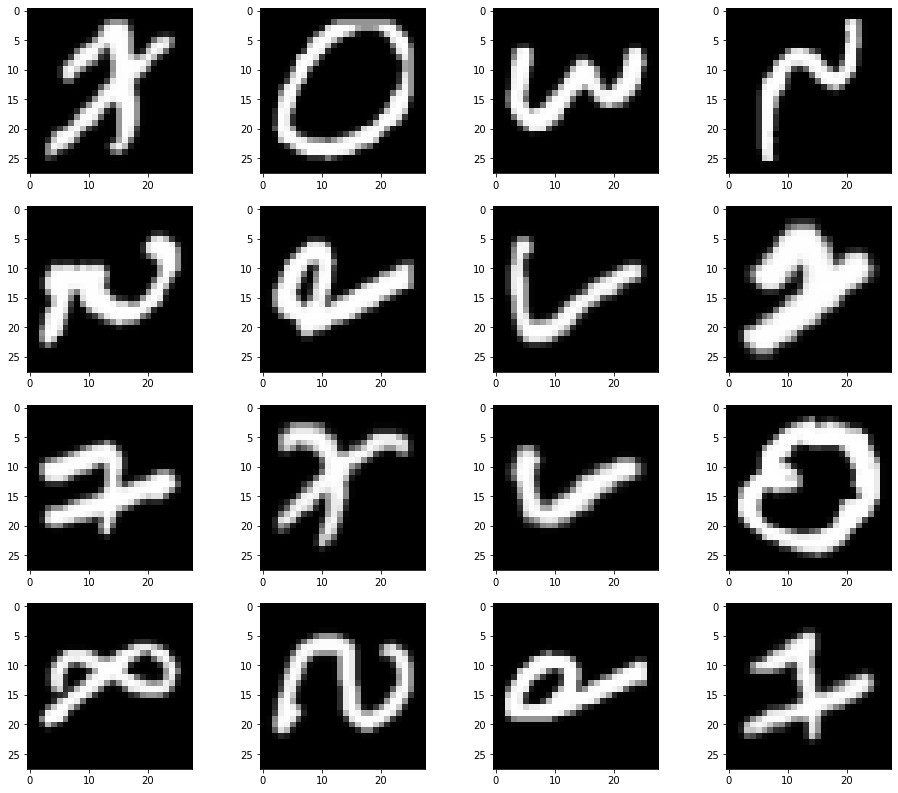

In [14]:
#
# Anzeige von Beispielen der Daten
#
for i in range(16):
    plt.subplot(4,4,1 + i)
    image = x_new[i].reshape((28,28))
    plt.imshow(image, cmap=plt.get_cmap('Greys_r'))
plt.show()

In [15]:
#
# Aus einem unklaren Grund sind die EMNIST Daten gedreht. Das muss korrigiert werden.
#
x_new_swap = np.swapaxes(x_new, 1, 2)

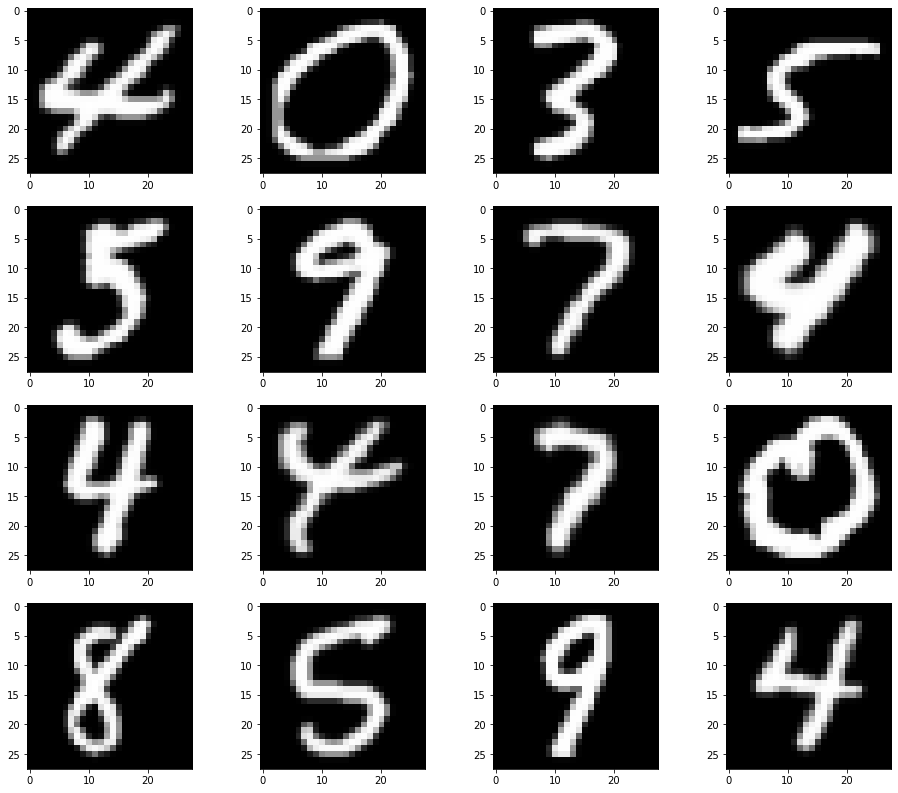

In [16]:
#
# Anzeige von Beispielen der Daten
#
for i in range(16):
    plt.subplot(4,4,1 + i)
    image = x_new_swap[i].reshape((28,28))
    plt.imshow(image, cmap=plt.get_cmap('Greys_r'))
plt.show()

In [17]:
# 
# Transformation
#
x_new_swap = x_new_swap.astype('float32')
x_new_swap = x_new_swap / 255.0

In [18]:
#
# Suche nach neuen Trainingsdaten
#
# Die Idee dahinter ist, dass wir nach Klassifizierungen suchen, die in einem bestimmten Bereich der confidence
# liegen. Zu hohe confidence steigert das Risiko, dass wir eh schon bekannte Daten dazunehmen, zu niedrige confidence
# steigert das Risiko, dass wir falsche Klassifizierungen dazunehmen.
#

candidateImages = []
candidateLabels = []
candidateConfidence = []
candidateIndex = []
candidateCount = 0
classDistribution = [0] * 10

for i in range(x_new_swap.shape[0]):
    
    image = x_new_swap[i].reshape((1,28,28,1))

    prediction_activation = loaded_model.predict([image])
    predictedClass = np.argmax ( prediction_activation[0] )
    confidence = prediction_activation[0][predictedClass]
    
    if confidence > 0.7 and confidence < 0.9:
        
        classDistribution[predictedClass]+= 1
        candidateCount+= 1
        candidateIndex.append(i)
        candidateImages.append(image)
        candidateLabels.append(predictedClass)
        candidateConfidence.append(confidence)

In [19]:
print('Anzahl der gefundenen Kandidaten ist {}'.format(candidateCount))

Anzahl der gefundenen Kandidaten ist 43


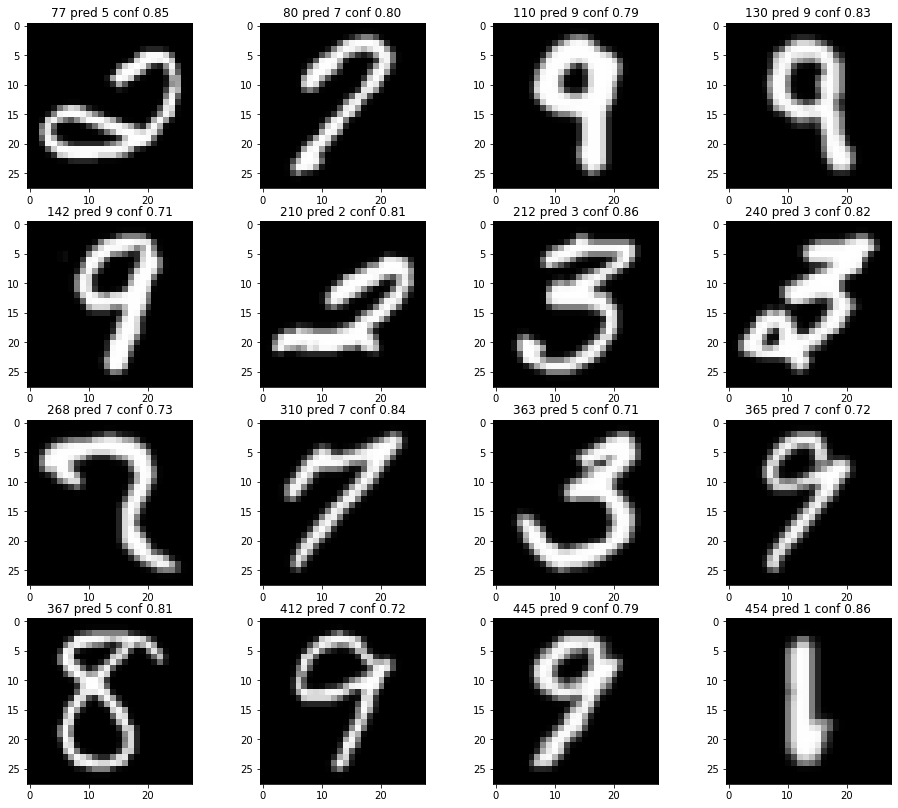

In [20]:
#
# Anzeige von Beispielen der Kandidaten
#
for i in range(16):
    ax = plt.subplot(4,4,1 + i) 
    ax.set_title('{} pred {} conf {:.2f}'.format ( candidateIndex[i], str(candidateLabels[i]), candidateConfidence[i] ))
    image = candidateImages[i].reshape((28,28))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.show()

In [21]:
#
# Manuelle Auswahl der Kandidaten durch den Domain Experten (active learning)
#
candidatesUsed =       [ 77,110,130,142,210,240,310,363,365,454,445,412,367,212]
candidatesUsedLabels = [  2,  9,  9,  9,  2,  3,  7,  3,  9,  1,  9,  9,  8,  3]

In [22]:
#
# Sammeln der Daten aus der Liste
#
candidateImagesUsed = []
candidateLabelsUsed = []
for candidate in range(len(candidatesUsed)):
    candidateLabelsUsed.append(candidatesUsedLabels[candidate])
    candidateImagesUsed.append(candidateImages[candidate])
    
x_train_used = np.asarray ( candidateImagesUsed )
y_train_used = np.asarray ( candidateLabelsUsed )


In [23]:
#
# Prepare new data for training
#
x_train_used = x_train_used.reshape((x_train_used.shape[0], 28, 28, 1))
y_train_used = to_categorical(y_train_used, num_classes=10)

In [24]:
#
# Zusammenführen der neuen und der alten Daten
#
x_train_active = np.concatenate((x_train_used, x_train), axis=0)
y_train_active = np.concatenate((y_train_used, y_train), axis=0)

In [25]:
x_train_active.shape

(60014, 28, 28, 1)

In [26]:
y_train_active.shape

(60014, 10)

In [27]:
#
# Prepare Model for retraining
#
optimizer = Adam(learning_rate=0.01)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
#
# Training mit neuen Daten
#
history = loaded_model.fit(x_train_active, y_train_active, validation_data=(x_test,y_test), batch_size=64, epochs=1 )

Train on 60014 samples, validate on 10000 samples
Epoch 1/1
60014/60014 [==============================] - 73s 1ms/step - loss: 0.0973 - accuracy: 0.9748 - val_loss: 0.0836 - val_accuracy: 0.9757


In [29]:
#
# Messen der Accuracy des alten Modelles
#
_, acc = loaded_model.evaluate(x_test, y_test, verbose=0)
print('New model accuracy {:.5f}'.format(acc))

New model accuracy 0.97570


In [30]:
#
# Alte model accuracy zum Vergleich 
#
print('Old model accuracy {:.5f}'.format(oldModelAccuracy))

Old model accuracy 0.99110


# Hyperparameter Optimization


Mehr zu hyperparameter optimization ist hier zu finden: 
- [https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d](https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d)
- [https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)


<img src="info.png" align="left"/> 

In [31]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

In [32]:
#
# Vorbereitung der MNIST Daten für RFC
#
x_train_rfc = np.reshape(x_train,(-1,28*28))
x_train_rfc.shape

(60000, 784)

In [33]:
y_train_rfc = np.argmax(y_train,axis=1)
y_train_rfc.shape

(60000,)

In [34]:
x_test_rfc = np.reshape(x_test,(-1,28*28))
y_test_rfc = np.argmax(y_test,axis=1)

## Random Forest Classifier

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

<img src="info.png" align="left"/> 

In [35]:
clf_rf = RandomForestClassifier(n_estimators=20,max_depth=6,max_features=0.2,n_jobs=-1)
clf_rf.fit(x_train_rfc, y_train_rfc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [36]:
y_pred_rf = clf_rf.predict(x_test_rfc)

In [37]:
acc_rf = accuracy_score(y_test_rfc, y_pred_rf)
print ("random forest accuracy: ",acc_rf)

random forest accuracy:  0.8729


## Wie finden wir die optimalen Parameter?

Es gibt mehrere python Module für die automatische Parameter Optimierung. Eines davon ist hyperopt. Hintergrundinformation dazu ist zu finden unter: [https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)

<img src="info.png" align="left"/> 

In [38]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
import os

# um mehr als einen worker zu verwenden sollte JOBLIB_TEMP_FOLDER global gesetzt sein
os.environ["JOBLIB_TEMP_FOLDER"] = "./data"

In [39]:
def hyperopt_train_test(params):
    clf = RandomForestClassifier( n_jobs=-1, **params)
    return cross_val_score(clf, x_train_rfc, y_train_rfc).mean()

In [40]:
space4rf = {
    'max_depth': hp.choice('max_depth', range(10,20)),
    'max_features': hp.uniform('max_features', 0.5, 1 ),
    'n_estimators': hp.choice('n_estimators', range(10,30)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

In [41]:
best = 0
def f(params):
    global best
    acc = hyperopt_train_test (params)
    if acc > best:
        best = acc
        print ( 'new best accuracy {}:{}'.format( best, params ) )
    return {'loss': -acc, 'status': STATUS_OK}

In [42]:
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=20, trials=trials)

new best accuracy 0.8586500000000001:{'criterion': 'gini', 'max_depth': 6, 'max_features': 0.4058176635131602, 'n_estimators': 18}
new best accuracy 0.9216833333333334:{'criterion': 'gini', 'max_depth': 12, 'max_features': 0.5819781504098287, 'n_estimators': 5}
new best accuracy 0.9460333333333333:{'criterion': 'entropy', 'max_depth': 17, 'max_features': 0.6588265895061095, 'n_estimators': 10}
new best accuracy 0.9487166666666667:{'criterion': 'entropy', 'max_depth': 14, 'max_features': 0.8136378959401187, 'n_estimators': 19}
100%|██████████| 20/20 [27:51<00:00, 83.58s/it, best loss: -0.9487166666666667] 


In [43]:
print ('found optimum {}'.format(best))

found optimum {'criterion': 1, 'max_depth': 13, 'max_features': 0.8136378959401187, 'n_estimators': 18}


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0 n_estimators
1 max_depth
2 max_features
3 criterion


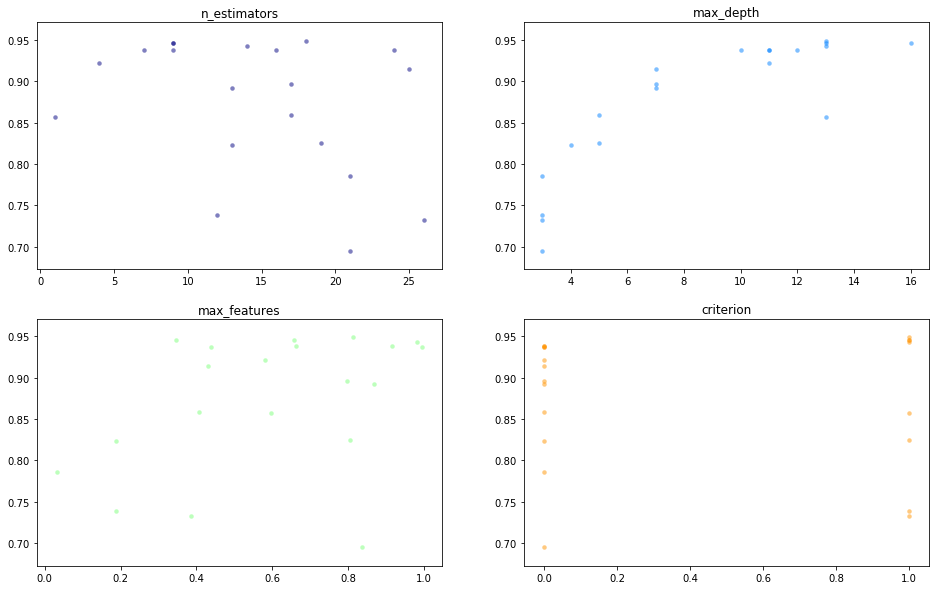

In [50]:
#
# Anzeige der Versuche
#
parameters = ['n_estimators', 'max_depth', 'max_features', 'criterion']

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    print (i, val)
    
    xs = np.array([ t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip( * sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap( float(i)/len(parameters) ))
    axes[i//2,i%2].set_title(val)

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0